In [1]:
import pandas as pd
import numpy as np
from enum import Enum
import chess
from pathlib import Path
from typing import Tuple
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [2]:
if torch.cuda.is_available():
    device = "cuda" 
    print("CUDA version:", torch.version.cuda)
    print("GPU:", torch.cuda.get_device_name())
else:
    device = "cpu"
    
device

CUDA version: 12.9
GPU: NVIDIA GeForce RTX 3070


'cuda'

In [3]:
RUN_ID = "run_2026_01_17_probs_seresnet_droppath_c64_v10"
model_save_name = "probs_seresnet_droppath_c64_v10"
# bn is bottleneck

In [4]:
class NPZChessDataset(Dataset):
    def __init__(self, npz_path: Path, sigma: float = 0.6):
        with np.load(npz_path) as data:
            self.X = torch.tensor(data["X"], dtype=torch.float32) # float32 for NNs
            self.y = torch.tensor(data["y"], dtype=torch.long) # long for CrossEntropyLoss
            self.scores = torch.tensor(data["scores"], dtype=torch.float32)
            self.num_classes = 7
            self.sigma = sigma
            self.class_indices = torch.arange(self.num_classes, dtype=torch.float32)

    def __len__(self) -> int:
        return self.X.shape[0]

    def score_to_continuous_index(self, score: float) -> float:
        """
        Maps Centipawn score to a continuous index (e.g. 400cp -> 1.5).
        """
        
        if score >= 500: 
            # Fade from 0.5 (at 500) to 0.0 (at 700)
            return max(0.0, 0.5 - (score - 500) / 200.0)
        
        if score <= -500:
            # Fade from 5.5 (at -500) to 6.0 (at -700)
            return min(6.0, 5.5 + (-500 - score) / 200.0)
        
        # Interpolate the Middle Classes
        # 300 to 500  -> Maps to 1.5 to 0.5
        if score >= 300: return 1.5 - (score - 300) / 200.0
        # 100 to 300  -> Maps to 2.5 to 1.5
        if score >= 100: return 2.5 - (score - 100) / 200.0
        # -100 to 100 -> Maps to 3.5 to 2.5
        if score >= -100: return 3.5 - (score - (-100)) / 200.0
        # -300 to -100 -> Maps to 4.5 to 3.5
        if score >= -300: return 4.5 - (score - (-300)) / 200.0
        # -500 to -300 -> Maps to 5.5 to 4.5
        if score > -500: return 5.5 - (score - (-500)) / 200.0
        
        return 3.0 
    
    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        score = self.scores[idx].item()
        target_idx = self.score_to_continuous_index(score)
        
        # Create Gaussian Distribution centered at target_idx
        dist = torch.exp(-((self.class_indices - target_idx) ** 2) / (2 * self.sigma ** 2))
        
        # Normalize so it sums to 1.0
        soft_target = dist / dist.sum()

        # return self.X[idx], self.y[idx]
        return self.X[idx], soft_target

In [5]:
BATCH_SIZE = 512
num_workers = 0

TRAIN_PATH = Path("./dataset_planes_cp/plane_train.npz")
VAL_PATH = Path("./dataset_planes_cp/plane_val.npz")
TEST_PATH = Path("./dataset_planes_cp/plane_test.npz") 

train_dataloader = DataLoader(dataset=NPZChessDataset(TRAIN_PATH), 
                              batch_size=BATCH_SIZE, 
                              num_workers=num_workers,
                              shuffle=True,
                              pin_memory=True)
val_dataloader = DataLoader(dataset=NPZChessDataset(VAL_PATH), 
                            batch_size=BATCH_SIZE, 
                            num_workers=num_workers,
                            shuffle=False,
                            pin_memory=True)
test_dataloader = DataLoader(dataset=NPZChessDataset(TEST_PATH), 
                             batch_size=BATCH_SIZE, 
                          num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

In [6]:
import time

start = time.time()
for i, (X, y) in enumerate(train_dataloader):
    if i == 100:  # measure 100 batches
        break
print("Avg batch load time:", (time.time() - start) / 100)


Avg batch load time: 0.041175272464752194


In [7]:
Xb, yb = next(iter(train_dataloader))
print("X batch shape:", Xb.shape, "dtype:", Xb.dtype)
print("y batch shape:", yb.shape, "dtype:", yb.dtype, "classes in batch:", yb.unique().tolist())

X batch shape: torch.Size([512, 19, 8, 8]) dtype: torch.float32
y batch shape: torch.Size([512, 7]) dtype: torch.float32 classes in batch: [1.5390388484403716e-22, 1.8077143966858269e-22, 1.8077145229035717e-22, 2.1230019056634916e-22, 2.30059456405017e-22, 2.4929496498727927e-22, 3.4360403089114576e-22, 3.722665661303184e-22, 4.369208991028615e-22, 6.016000180670424e-22, 1.334754873066261e-21, 1.334754974040457e-21, 1.8337917653188306e-21, 1.9851353232088824e-21, 2.517711804361063e-21, 3.454282004214435e-21, 4.04498347342463e-21, 4.376932103373797e-21, 7.018715547011237e-21, 8.212169149863331e-21, 1.1235834174997158e-20, 1.2150409973558108e-20, 1.2150410781351675e-20, 1.3138742979336224e-20, 1.536081344535648e-20, 2.4517281158076552e-20, 2.4517282773663686e-20, 2.6499246295431953e-20, 2.86404049266126e-20, 3.095261384559413e-20, 3.6146500298860195e-20, 3.905876089758932e-20, 4.2203262146815514e-20, 5.32215728623118e-20, 5.322157609348607e-20, 5.749384763504882e-20, 6.708419258168569e-

In [8]:
class PositionLabel(Enum):
    WHITE_WINNING = 0
    WHITE_DECISIVE = 1
    WHITE_BETTER = 2
    EQUAL = 3
    BLACK_BETTER = 4
    BLACK_DECISIVE = 5
    BLACK_WINNING = 6

In [9]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, drop_prob=0.0):
        super().__init__()
        
        # bias = False because BatchNorm effectively cancels any bias term
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 =  nn.BatchNorm2d(channels)
        self.bn2 =  nn.BatchNorm2d(channels)
        self.relu = nn.ReLU()
        self.se = SEBlock(channels, reduction=8)
        self.drop_path = DropPath(drop_prob) if drop_prob > 0. else nn.Identity()

    # x is shape [19,8,8]
    def forward(self, x):
        identity = x 
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.se(x)
        x = self.drop_path(x)
        x += identity
        x = self.relu(x)
        # x = self.dropout(x) # adding causes val acc drop 15%
        return x

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Squeeze: Global Average Pooling (turns Cx8x8 tensor into Cx1x1 tensor (not flattened))
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        
        # Excitation: A tiny fully connected network to learn channel weights
        self.mlp = nn.Sequential(
            nn.Linear(channels, channels // reduction), # Compress
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels), # Expand
            nn.Sigmoid() # Output a (0.0 to 1.0) for importance
        )

    def forward(self, x):
        batch, channels, _, _ = x.size()
        
        # Calculate importance scores
        y = self.avg_pool(x).view(batch, channels)
        y = self.mlp(y).view(batch, channels, 1, 1)
        
        # Scale the original input by these scores
        return x * y.expand_as(x)
    
class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)

        # Create a mask of 1s and 0s
        random_tensor = x.new_empty(shape).bernoulli_(keep_prob)

        # Apply mask and scale output to maintain expected value
        return x.div(keep_prob) * random_tensor
    
class SEResNet(nn.Module):
    def __init__(self, in_channels=19, channels=128, num_blocks=10, num_classes=7, drop_path_rate=0.2):
        super().__init__()
        # Initial convolution on board
        self.initialconv = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU()
        )

        dpr = [x.item() for x in torch.linspace(start=0, end=drop_path_rate, steps=num_blocks)]

        # Main residual block
        blocks = []
        for i in range(num_blocks):
            blocks.append(ResidualBlock(channels, drop_prob=dpr[i]))
        self.res_tower = nn.Sequential(*blocks)


        # Reduces channels to 32 before flattening
        self.bottleneck_channels = 32
        self.bottleneck = nn.Sequential(
            nn.Conv2d(channels, self.bottleneck_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(self.bottleneck_channels),
            nn.ReLU()
        )

        # Classifier
        self.flatten_dim = 64 * 8 * 8
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)      
        )

    def forward(self, x):
        x = self.initialconv(x)
        x = self.res_tower(x)
        # x = self.bottleneck(x)
        x = self.classifier(x)
        return x

In [10]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               scaler: torch.amp.GradScaler,
               device=device) -> tuple[float, float]:
    """
    Performs one training epoch for the given model.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in train mode
    model.train()

    train_loss, train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # X and Y are both shape (BATCH_SIZE,)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        with torch.amp.autocast(device):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
        
        # Backpropagation
        scaler.scale(loss).backward()

        # Update weights
        scaler.step(optimizer)
        scaler.update()  
        
        train_loss += loss.item()

        # Calculate accuracy metrics
        """softmax and argmax dim=1 because tensor of shape (batchsize, num_classes)"""
        y_pred_class = torch.argmax(y_pred, dim=-1) # y_pred_class.shape = (BATCH_SIZE,)
        # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

        # Remove for non prob ablation
        y_true_class = torch.argmax(y, dim=-1)
        train_acc += (y_pred_class == y_true_class).sum().item()/len(y_pred)
        
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

In [11]:
def eval_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device) -> tuple[float, float]:
    """
    Evaluates the given model on the given dataloader without gradient updates.
    Dataloader should either be the validation or test dataloader.
    Returns the average loss and accuracy across all batches.
    """
    
    # Put model in eval mode
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward Pass
            test_pred = model(X)

            # Calculate the loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            # Calculate accuracy metrics
            test_pred_labels = torch.argmax(test_pred, dim=1)
            # test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

            # Remove for non prob ablation
            y_true_labels = torch.argmax(y, dim=1)
            test_acc += (test_pred_labels == y_true_labels).sum().item()/len(test_pred_labels)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

In [12]:
from tqdm import tqdm
import copy

def run_experiment(model: torch.nn.Module,
                   model_save_name: str,
                   train_dataloader: torch.utils.data.DataLoader,
                   val_dataloader: torch.utils.data.DataLoader,
                   loss_fn: torch.nn.Module,
                   optimizer: torch.optim.Optimizer,
                   scaler: torch.amp.GradScaler,
                   epochs: int,
                   patience: int,
                   device=device):
    
    results = {"train_loss": [],
               "train_acc": [],
               "val_loss": [],
               "val_acc": []}
    
    best_val_acc = 0.0
    best_model_weights = None
    patience_counter = 0 
    
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.1, patience=3
    # )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=epochs,      
        eta_min=1e-6         
    )
    
    print(f"Starting Training: {model_save_name}")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)
        val_loss, val_acc = eval_step(model=model,
                                      dataloader=val_dataloader,
                                      loss_fn=loss_fn,
                                      device=device)
        
        # scheduler.step(val_loss)
        scheduler.step()
        
        if val_acc > best_val_acc: 
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            
            print(f"Epoch: {epoch} | New Best Val Acc: {val_acc:.4f} (Saved)")
            torch.save(model.state_dict(), f"models/{model_save_name}.pth")
        else:
            patience_counter += 1
            print(f"Epoch: No improvement. Patience {patience_counter}/{patience}")

        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)

        if patience_counter >= patience:
            print(f"\n[Early Stopping] No improvement for {patience} epochs. Stopping.")
            break 

    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        print(f"\nLoaded best model weights with Val Acc: {best_val_acc:.4f}")

    return results

In [13]:
from torchinfo import summary

model = SEResNet(in_channels=19, 
                 channels=64, 
                 num_blocks=10, 
                 num_classes=7).to(device)

summary(model, input_size=(BATCH_SIZE, 19, 8, 8))

Layer (type:depth-idx)                        Output Shape              Param #
SEResNet                                      [512, 7]                  2,112
├─Sequential: 1-1                             [512, 64, 8, 8]           --
│    └─Conv2d: 2-1                            [512, 64, 8, 8]           10,944
│    └─BatchNorm2d: 2-2                       [512, 64, 8, 8]           128
│    └─ReLU: 2-3                              [512, 64, 8, 8]           --
├─Sequential: 1-2                             [512, 64, 8, 8]           --
│    └─ResidualBlock: 2-4                     [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-1                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-2                  [512, 64, 8, 8]           128
│    │    └─ReLU: 3-3                         [512, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                       [512, 64, 8, 8]           36,864
│    │    └─BatchNorm2d: 3-5                  [512, 64, 8, 8]           128
│ 

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 100

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=0.001,
                              weight_decay=0.01)

scaler = torch.amp.GradScaler("cuda")

result = run_experiment(model=model,
                        model_save_name=model_save_name,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        scaler=scaler,
                        epochs=NUM_EPOCHS,
                        patience=NUM_EPOCHS + 1,
                        device=device)

Starting Training: probs_seresnet_droppath_c64_v10


  1%|          | 1/100 [08:06<13:23:09, 486.76s/it]

Epoch: 0 | New Best Val Acc: 0.5542 (Saved)
Epoch: 0 | Train Loss: 1.3841 | Val Loss: 1.2794 | Val Acc: 0.5542


  2%|▏         | 2/100 [15:21<12:25:03, 456.16s/it]

Epoch: 1 | New Best Val Acc: 0.5971 (Saved)
Epoch: 1 | Train Loss: 1.2487 | Val Loss: 1.2122 | Val Acc: 0.5971


  3%|▎         | 3/100 [22:12<11:44:04, 435.51s/it]

Epoch: 2 | New Best Val Acc: 0.6123 (Saved)
Epoch: 2 | Train Loss: 1.2017 | Val Loss: 1.1893 | Val Acc: 0.6123


  4%|▍         | 4/100 [29:02<11:20:55, 425.58s/it]

Epoch: 3 | New Best Val Acc: 0.6222 (Saved)
Epoch: 3 | Train Loss: 1.1747 | Val Loss: 1.1739 | Val Acc: 0.6222


  5%|▌         | 5/100 [35:51<11:04:08, 419.46s/it]

Epoch: 4 | New Best Val Acc: 0.6315 (Saved)
Epoch: 4 | Train Loss: 1.1565 | Val Loss: 1.1627 | Val Acc: 0.6315


  6%|▌         | 6/100 [42:39<10:50:53, 415.46s/it]

Epoch: 5 | New Best Val Acc: 0.6451 (Saved)
Epoch: 5 | Train Loss: 1.1435 | Val Loss: 1.1380 | Val Acc: 0.6451


  7%|▋         | 7/100 [49:27<10:40:17, 413.09s/it]

Epoch: No improvement. Patience 1/101
Epoch: 6 | Train Loss: 1.1334 | Val Loss: 1.2067 | Val Acc: 0.6030


  8%|▊         | 8/100 [56:16<10:31:17, 411.71s/it]

Epoch: 7 | New Best Val Acc: 0.6525 (Saved)
Epoch: 7 | Train Loss: 1.1258 | Val Loss: 1.1280 | Val Acc: 0.6525


  9%|▉         | 9/100 [1:04:04<10:51:12, 429.37s/it]

Epoch: No improvement. Patience 1/101
Epoch: 8 | Train Loss: 1.1193 | Val Loss: 1.1332 | Val Acc: 0.6518


 10%|█         | 10/100 [1:10:50<10:33:06, 422.08s/it]

Epoch: No improvement. Patience 2/101
Epoch: 9 | Train Loss: 1.1136 | Val Loss: 1.1660 | Val Acc: 0.6311


 11%|█         | 11/100 [1:17:36<10:18:57, 417.27s/it]

Epoch: 10 | New Best Val Acc: 0.6612 (Saved)
Epoch: 10 | Train Loss: 1.1092 | Val Loss: 1.1200 | Val Acc: 0.6612


 12%|█▏        | 12/100 [1:24:22<10:06:57, 413.84s/it]

Epoch: No improvement. Patience 1/101
Epoch: 11 | Train Loss: 1.1054 | Val Loss: 1.2794 | Val Acc: 0.5634


 13%|█▎        | 13/100 [1:31:08<9:56:49, 411.60s/it] 

Epoch: 12 | New Best Val Acc: 0.6694 (Saved)
Epoch: 12 | Train Loss: 1.1021 | Val Loss: 1.1093 | Val Acc: 0.6694


 14%|█▍        | 14/100 [1:38:04<9:51:54, 412.96s/it]

Epoch: No improvement. Patience 1/101
Epoch: 13 | Train Loss: 1.0988 | Val Loss: 1.1257 | Val Acc: 0.6554


 15%|█▌        | 15/100 [1:45:26<9:57:23, 421.69s/it]

Epoch: 14 | New Best Val Acc: 0.6717 (Saved)
Epoch: 14 | Train Loss: 1.0960 | Val Loss: 1.1065 | Val Acc: 0.6717


 16%|█▌        | 16/100 [1:52:12<9:43:29, 416.77s/it]

Epoch: No improvement. Patience 1/101
Epoch: 15 | Train Loss: 1.0938 | Val Loss: 1.1194 | Val Acc: 0.6576


 17%|█▋        | 17/100 [1:59:01<9:33:21, 414.48s/it]

Epoch: No improvement. Patience 2/101
Epoch: 16 | Train Loss: 1.0913 | Val Loss: 1.1088 | Val Acc: 0.6666


 18%|█▊        | 18/100 [2:05:46<9:22:44, 411.76s/it]

Epoch: 17 | New Best Val Acc: 0.6740 (Saved)
Epoch: 17 | Train Loss: 1.0894 | Val Loss: 1.0990 | Val Acc: 0.6740


 19%|█▉        | 19/100 [2:12:23<9:09:39, 407.16s/it]

Epoch: No improvement. Patience 1/101
Epoch: 18 | Train Loss: 1.0874 | Val Loss: 1.1016 | Val Acc: 0.6736


 20%|██        | 20/100 [2:19:17<9:05:44, 409.30s/it]

Epoch: No improvement. Patience 2/101
Epoch: 19 | Train Loss: 1.0857 | Val Loss: 1.1242 | Val Acc: 0.6543


 21%|██        | 21/100 [2:26:12<9:01:15, 411.09s/it]

Epoch: No improvement. Patience 3/101
Epoch: 20 | Train Loss: 1.0843 | Val Loss: 1.1251 | Val Acc: 0.6569


 22%|██▏       | 22/100 [2:33:11<8:57:26, 413.41s/it]

Epoch: No improvement. Patience 4/101
Epoch: 21 | Train Loss: 1.0826 | Val Loss: 1.1095 | Val Acc: 0.6693


 23%|██▎       | 23/100 [2:40:02<8:49:43, 412.77s/it]

Epoch: 22 | New Best Val Acc: 0.6751 (Saved)
Epoch: 22 | Train Loss: 1.0813 | Val Loss: 1.1030 | Val Acc: 0.6751


 24%|██▍       | 24/100 [2:46:51<8:41:10, 411.45s/it]

Epoch: No improvement. Patience 1/101
Epoch: 23 | Train Loss: 1.0799 | Val Loss: 1.1122 | Val Acc: 0.6664


 25%|██▌       | 25/100 [2:53:40<8:33:22, 410.71s/it]

Epoch: 24 | New Best Val Acc: 0.6778 (Saved)
Epoch: 24 | Train Loss: 1.0785 | Val Loss: 1.0986 | Val Acc: 0.6778


 26%|██▌       | 26/100 [3:00:37<8:28:57, 412.66s/it]

Epoch: 25 | New Best Val Acc: 0.6821 (Saved)
Epoch: 25 | Train Loss: 1.0769 | Val Loss: 1.0959 | Val Acc: 0.6821


 27%|██▋       | 27/100 [3:07:34<8:23:50, 414.12s/it]

Epoch: No improvement. Patience 1/101
Epoch: 26 | Train Loss: 1.0760 | Val Loss: 1.0968 | Val Acc: 0.6779


 28%|██▊       | 28/100 [3:14:31<8:17:53, 414.91s/it]

Epoch: No improvement. Patience 2/101
Epoch: 27 | Train Loss: 1.0746 | Val Loss: 1.0994 | Val Acc: 0.6763


 29%|██▉       | 29/100 [3:21:50<8:19:24, 422.04s/it]

Epoch: No improvement. Patience 3/101
Epoch: 28 | Train Loss: 1.0733 | Val Loss: 1.1049 | Val Acc: 0.6714


 30%|███       | 30/100 [3:29:05<8:16:47, 425.82s/it]

Epoch: No improvement. Patience 4/101
Epoch: 29 | Train Loss: 1.0719 | Val Loss: 1.1323 | Val Acc: 0.6483


 31%|███       | 31/100 [3:36:22<8:13:37, 429.24s/it]

Epoch: No improvement. Patience 5/101
Epoch: 30 | Train Loss: 1.0709 | Val Loss: 1.0978 | Val Acc: 0.6756


 32%|███▏      | 32/100 [3:43:53<8:13:55, 435.82s/it]

Epoch: No improvement. Patience 6/101
Epoch: 31 | Train Loss: 1.0696 | Val Loss: 1.0927 | Val Acc: 0.6801


 33%|███▎      | 33/100 [3:51:48<8:19:45, 447.54s/it]

Epoch: No improvement. Patience 7/101
Epoch: 32 | Train Loss: 1.0684 | Val Loss: 1.1201 | Val Acc: 0.6610


 34%|███▍      | 34/100 [4:06:22<10:33:01, 575.48s/it]

Epoch: No improvement. Patience 8/101
Epoch: 33 | Train Loss: 1.0674 | Val Loss: 1.0993 | Val Acc: 0.6779
Epoch: 34 | New Best Val Acc: 0.6836 (Saved)


 35%|███▌      | 35/100 [4:14:51<10:01:50, 555.55s/it]

Epoch: 34 | Train Loss: 1.0660 | Val Loss: 1.0930 | Val Acc: 0.6836


 36%|███▌      | 36/100 [4:23:06<9:33:23, 537.55s/it] 

Epoch: 35 | New Best Val Acc: 0.6841 (Saved)
Epoch: 35 | Train Loss: 1.0651 | Val Loss: 1.0911 | Val Acc: 0.6841


 37%|███▋      | 37/100 [4:30:32<8:55:29, 509.99s/it]

Epoch: No improvement. Patience 1/101
Epoch: 36 | Train Loss: 1.0638 | Val Loss: 1.1011 | Val Acc: 0.6724


 38%|███▊      | 38/100 [4:37:21<8:15:47, 479.79s/it]

Epoch: No improvement. Patience 2/101
Epoch: 37 | Train Loss: 1.0626 | Val Loss: 1.0973 | Val Acc: 0.6809


 39%|███▉      | 39/100 [4:44:09<7:45:37, 457.99s/it]

Epoch: No improvement. Patience 3/101
Epoch: 38 | Train Loss: 1.0614 | Val Loss: 1.1361 | Val Acc: 0.6556


 40%|████      | 40/100 [4:50:56<7:22:56, 442.94s/it]

Epoch: No improvement. Patience 4/101
Epoch: 39 | Train Loss: 1.0602 | Val Loss: 1.1069 | Val Acc: 0.6742


 41%|████      | 41/100 [4:57:39<7:03:48, 430.99s/it]

Epoch: No improvement. Patience 5/101
Epoch: 40 | Train Loss: 1.0590 | Val Loss: 1.1145 | Val Acc: 0.6709


 42%|████▏     | 42/100 [5:04:37<6:52:45, 426.99s/it]

Epoch: 41 | New Best Val Acc: 0.6869 (Saved)
Epoch: 41 | Train Loss: 1.0579 | Val Loss: 1.0891 | Val Acc: 0.6869


 43%|████▎     | 43/100 [5:11:34<6:42:40, 423.87s/it]

Epoch: 42 | New Best Val Acc: 0.6878 (Saved)
Epoch: 42 | Train Loss: 1.0566 | Val Loss: 1.0896 | Val Acc: 0.6878


 44%|████▍     | 44/100 [5:18:15<6:29:09, 416.96s/it]

Epoch: No improvement. Patience 1/101
Epoch: 43 | Train Loss: 1.0553 | Val Loss: 1.0941 | Val Acc: 0.6821


 45%|████▌     | 45/100 [5:25:15<6:23:07, 417.96s/it]

Epoch: No improvement. Patience 2/101
Epoch: 44 | Train Loss: 1.0542 | Val Loss: 1.0895 | Val Acc: 0.6858


 46%|████▌     | 46/100 [5:34:47<6:57:52, 464.30s/it]

Epoch: No improvement. Patience 3/101
Epoch: 45 | Train Loss: 1.0528 | Val Loss: 1.0888 | Val Acc: 0.6873


 47%|████▋     | 47/100 [5:43:44<7:09:11, 485.89s/it]

Epoch: No improvement. Patience 4/101
Epoch: 46 | Train Loss: 1.0517 | Val Loss: 1.0970 | Val Acc: 0.6814


 48%|████▊     | 48/100 [5:52:10<7:06:27, 492.06s/it]

Epoch: No improvement. Patience 5/101
Epoch: 47 | Train Loss: 1.0505 | Val Loss: 1.0980 | Val Acc: 0.6804
Epoch: 48 | New Best Val Acc: 0.6881 (Saved)


 49%|████▉     | 49/100 [6:00:43<7:03:38, 498.40s/it]

Epoch: 48 | Train Loss: 1.0491 | Val Loss: 1.0891 | Val Acc: 0.6881


 50%|█████     | 50/100 [6:08:39<6:49:46, 491.74s/it]

Epoch: No improvement. Patience 1/101
Epoch: 49 | Train Loss: 1.0479 | Val Loss: 1.1069 | Val Acc: 0.6754


 51%|█████     | 51/100 [6:16:11<6:31:43, 479.65s/it]

Epoch: No improvement. Patience 2/101
Epoch: 50 | Train Loss: 1.0467 | Val Loss: 1.0902 | Val Acc: 0.6855


 52%|█████▏    | 52/100 [6:23:42<6:16:56, 471.19s/it]

Epoch: No improvement. Patience 3/101
Epoch: 51 | Train Loss: 1.0455 | Val Loss: 1.1087 | Val Acc: 0.6714


 53%|█████▎    | 53/100 [6:30:54<5:59:45, 459.26s/it]

Epoch: 52 | New Best Val Acc: 0.6887 (Saved)
Epoch: 52 | Train Loss: 1.0440 | Val Loss: 1.0869 | Val Acc: 0.6887


 54%|█████▍    | 54/100 [6:37:49<5:42:04, 446.18s/it]

Epoch: No improvement. Patience 1/101
Epoch: 53 | Train Loss: 1.0426 | Val Loss: 1.0937 | Val Acc: 0.6820


 55%|█████▌    | 55/100 [6:44:44<5:27:31, 436.70s/it]

Epoch: No improvement. Patience 2/101
Epoch: 54 | Train Loss: 1.0414 | Val Loss: 1.0932 | Val Acc: 0.6865


 56%|█████▌    | 56/100 [6:51:34<5:14:26, 428.79s/it]

Epoch: No improvement. Patience 3/101
Epoch: 55 | Train Loss: 1.0400 | Val Loss: 1.0949 | Val Acc: 0.6856


 57%|█████▋    | 57/100 [6:58:28<5:03:59, 424.18s/it]

Epoch: 56 | New Best Val Acc: 0.6892 (Saved)
Epoch: 56 | Train Loss: 1.0387 | Val Loss: 1.0882 | Val Acc: 0.6892


 58%|█████▊    | 58/100 [7:06:31<5:09:14, 441.77s/it]

Epoch: No improvement. Patience 1/101
Epoch: 57 | Train Loss: 1.0371 | Val Loss: 1.0924 | Val Acc: 0.6872


 59%|█████▉    | 59/100 [7:15:18<5:19:28, 467.52s/it]

Epoch: No improvement. Patience 2/101
Epoch: 58 | Train Loss: 1.0356 | Val Loss: 1.0917 | Val Acc: 0.6886


 60%|██████    | 60/100 [7:22:10<5:00:34, 450.86s/it]

Epoch: No improvement. Patience 3/101
Epoch: 59 | Train Loss: 1.0342 | Val Loss: 1.0942 | Val Acc: 0.6858


 61%|██████    | 61/100 [7:28:59<4:44:54, 438.32s/it]

Epoch: 60 | New Best Val Acc: 0.6893 (Saved)
Epoch: 60 | Train Loss: 1.0328 | Val Loss: 1.0938 | Val Acc: 0.6893


 62%|██████▏   | 62/100 [7:35:52<4:32:41, 430.57s/it]

Epoch: No improvement. Patience 1/101
Epoch: 61 | Train Loss: 1.0312 | Val Loss: 1.0993 | Val Acc: 0.6870


 63%|██████▎   | 63/100 [7:42:45<4:22:20, 425.42s/it]

Epoch: 62 | New Best Val Acc: 0.6900 (Saved)
Epoch: 62 | Train Loss: 1.0298 | Val Loss: 1.0910 | Val Acc: 0.6900


 64%|██████▍   | 64/100 [7:49:53<4:15:38, 426.08s/it]

Epoch: 63 | New Best Val Acc: 0.6916 (Saved)
Epoch: 63 | Train Loss: 1.0281 | Val Loss: 1.0872 | Val Acc: 0.6916


 65%|██████▌   | 65/100 [7:57:01<4:08:56, 426.77s/it]

Epoch: No improvement. Patience 1/101
Epoch: 64 | Train Loss: 1.0268 | Val Loss: 1.0900 | Val Acc: 0.6902


 66%|██████▌   | 66/100 [8:06:42<4:27:59, 472.94s/it]

Epoch: No improvement. Patience 2/101
Epoch: 65 | Train Loss: 1.0252 | Val Loss: 1.1049 | Val Acc: 0.6808


 67%|██████▋   | 67/100 [8:14:23<4:18:11, 469.45s/it]

Epoch: No improvement. Patience 3/101
Epoch: 66 | Train Loss: 1.0237 | Val Loss: 1.0990 | Val Acc: 0.6839
Epoch: 67 | New Best Val Acc: 0.6926 (Saved)


 68%|██████▊   | 68/100 [8:22:02<4:08:45, 466.43s/it]

Epoch: 67 | Train Loss: 1.0221 | Val Loss: 1.0914 | Val Acc: 0.6926


 69%|██████▉   | 69/100 [8:29:03<3:53:51, 452.61s/it]

Epoch: No improvement. Patience 1/101
Epoch: 68 | Train Loss: 1.0203 | Val Loss: 1.0934 | Val Acc: 0.6890


 70%|███████   | 70/100 [8:36:01<3:41:13, 442.44s/it]

Epoch: No improvement. Patience 2/101
Epoch: 69 | Train Loss: 1.0188 | Val Loss: 1.0908 | Val Acc: 0.6926


 71%|███████   | 71/100 [8:43:29<3:34:32, 443.90s/it]

Epoch: No improvement. Patience 3/101
Epoch: 70 | Train Loss: 1.0172 | Val Loss: 1.0956 | Val Acc: 0.6896


 72%|███████▏  | 72/100 [8:51:27<3:32:01, 454.33s/it]

Epoch: No improvement. Patience 4/101
Epoch: 71 | Train Loss: 1.0156 | Val Loss: 1.0942 | Val Acc: 0.6920
Epoch: 72 | New Best Val Acc: 0.6928 (Saved)
Epoch: 72 | Train Loss: 1.0140 | Val Loss: 1.0953 | Val Acc: 0.6928


 74%|███████▍  | 74/100 [9:07:54<3:26:59, 477.66s/it]

Epoch: No improvement. Patience 1/101
Epoch: 73 | Train Loss: 1.0123 | Val Loss: 1.0944 | Val Acc: 0.6926
Epoch: 74 | New Best Val Acc: 0.6945 (Saved)
Epoch: 74 | Train Loss: 1.0106 | Val Loss: 1.0952 | Val Acc: 0.6945


 76%|███████▌  | 76/100 [9:22:55<3:05:25, 463.54s/it]

Epoch: No improvement. Patience 1/101
Epoch: 75 | Train Loss: 1.0092 | Val Loss: 1.0980 | Val Acc: 0.6920


 77%|███████▋  | 77/100 [9:30:13<2:54:46, 455.92s/it]

Epoch: No improvement. Patience 2/101
Epoch: 76 | Train Loss: 1.0077 | Val Loss: 1.0978 | Val Acc: 0.6928


 78%|███████▊  | 78/100 [9:37:57<2:48:02, 458.31s/it]

Epoch: No improvement. Patience 3/101
Epoch: 77 | Train Loss: 1.0061 | Val Loss: 1.0979 | Val Acc: 0.6927


 79%|███████▉  | 79/100 [9:45:04<2:37:07, 448.93s/it]

Epoch: No improvement. Patience 4/101
Epoch: 78 | Train Loss: 1.0046 | Val Loss: 1.0976 | Val Acc: 0.6937


 80%|████████  | 80/100 [9:51:57<2:26:01, 438.07s/it]

Epoch: No improvement. Patience 5/101
Epoch: 79 | Train Loss: 1.0031 | Val Loss: 1.1037 | Val Acc: 0.6920


In [ ]:
piece_to_index = {"P":0,
                  "N":1,
                  "B":2,
                  "R":3,
                  "Q":4,
                  "K":5,
                  "p":6,
                  "n":7,
                  "b":8,
                  "r":9,
                  "q":10,
                  "k":11}

In [ ]:
def fen_to_tensor(fen):
    """
    Converts FEN into a (19, 8, 8) tensor.
    """
    board = chess.Board(fen)
    tensor = np.zeros((19, 8, 8), dtype=np.uint8)

    piece_to_channel = {
        "P": 0, "N": 1, "B": 2, "R": 3, "Q": 4, "K": 5,
        "p": 6, "n": 7, "b": 8, "r": 9, "q": 10, "k": 11
    }

    for square, piece in board.piece_map().items():
        channel = piece_to_channel[piece.symbol()]
        row, col = divmod(square, 8)
        tensor[channel, row, col] = 1

    
    if board.turn == chess.WHITE:
        tensor[12, :, :] = 1
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[13, :, :] = 1
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[14, :, :] = 1
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[15, :, :] = 1
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[16, :, :] = 1
    if board.is_check():
        tensor[17, :, :] = 1

    if board.ep_square is not None:
        row, col = divmod(board.ep_square, 8)
        tensor[18, row, col] = 1

    return tensor

Model Prediction:  5
Stockfish Evaluation:  5


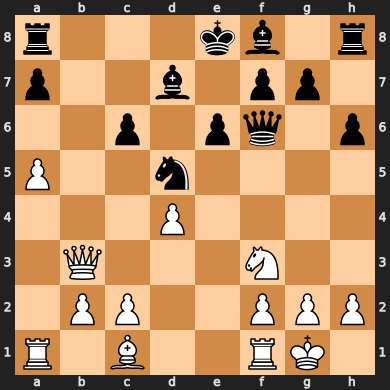

In [ ]:
def check_model_prediction(model: torch.nn.Module,
                           random_fen: str,
                           fen_class: int,
                           device=device):
    """Takes the given fen to see the board, predicted score and actual score"""

    numpy_fen = fen_to_tensor(random_fen)
    torch_fen = torch.tensor(numpy_fen, dtype=torch.float32).unsqueeze(0).to(device)
    pred = torch.argmax(model(torch_fen), dim=-1)
    print("Model Prediction: ", pred.item())
    print("Stockfish Evaluation: ", fen_class)

# Remember to update fen_class manually
random_fen = "r3kb1r/p2b1pp1/2p1pq1p/P2n4/3P4/1Q3N2/1PP2PPP/R1B2RK1 b kq - 2 14"
check_model_prediction(model=model,
                       random_fen=random_fen,
                       fen_class=5, # remember to manually set 
                       device=device)

board = chess.Board(random_fen)
board

In [ ]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

model.eval()
with torch.inference_mode():
    for X, y in val_dataloader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())

        # all_labels.extend(y.cpu().numpy())
        true_labels = y.argmax(dim=1) 
        all_labels.extend(true_labels.cpu().numpy())

print(classification_report(all_labels, all_preds))


              precision    recall  f1-score   support

           0       0.83      0.82      0.82     85756
           1       0.65      0.64      0.65     85446
           2       0.64      0.64      0.64     85601
           3       0.62      0.68      0.65     86225
           4       0.66      0.65      0.65     85229
           5       0.66      0.63      0.65     85573
           6       0.83      0.82      0.82     85377

    accuracy                           0.70    599207
   macro avg       0.70      0.70      0.70    599207
weighted avg       0.70      0.70      0.70    599207



In [ ]:
import json
import time

LOGS_DIR = f"experiments/logs/{model_save_name}"

def save_config_metadata(experiment_name: str, 
                         model: torch.nn.Module, 
                         hyperparams: dict, 
                         dataset_paths: dict,
                         save_dir: str = LOGS_DIR):
    """
    Saves all 'static' setup details: Model architecture, parameter counts, 
    datasets used, and hyperparameters.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    # Model Metadata
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    config_data = {
        "experiment_name": experiment_name,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_architecture": {
            "class_name": model.__class__.__name__,
            "total_parameters": total_params,
            "trainable_parameters": trainable_params,
            "input_dim": hyperparams.get("input_shape", "unknown"),
            "output_dim": hyperparams.get("output_shape", "unknown"),
            "structure_summary": str(model)
        },
        "datasets": dataset_paths,
        "hyperparameters": hyperparams,
        "device": torch.cuda.get_device_name() if torch.cuda.is_available() else "cpu"
    }

    file_path = f"{save_dir}/{experiment_name}_config.json"
    with open(file_path, "w") as f:
        json.dump(config_data, f, indent=4)
    
    print(f"[Config] Saved metadata to {file_path}")
    
def save_training_logs(experiment_name: str, 
                       results_dict: dict, 
                       save_dir: str = LOGS_DIR):
    """
    Saves the epoch-by-epoch learning curves (Loss/Acc) to CSV.
    Expects results_dict to be the output from your run_experiment function.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    df = pd.DataFrame(results_dict)
    
    if "epoch" not in df.columns:
        df["epoch"] = range(1, len(df) + 1)
        
    file_path = f"{save_dir}/{experiment_name}_learning_curves.csv"
    df.to_csv(file_path, index=False)
    
    print(f"[Logs] Saved training history to {file_path}")

In [ ]:
import numpy as np
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from typing import List, Dict, Tuple

RESULTS_DIR = f"experiments/results/{model_save_name}"

def calculate_ordinal_metrics(preds: np.ndarray,
                              labels: np.ndarray) -> Dict[str, float]:
    """
    Calculates metrics specific to ordinal classification (where Class 0 is close to Class 1).
    """
    abs_diffs = np.abs(preds - labels)
    
    metrics = {
        "mae": float(np.mean(abs_diffs)),
        "off_by_one_accuracy": float(np.mean(abs_diffs <= 1)),
        "off_by_two_accuracy": float(np.mean(abs_diffs <= 2))
    }
    return metrics

def categorize_failures(preds: np.ndarray, 
                        labels: np.ndarray) -> Dict[int, List[int]]:
    """
    Categorizes errors by magnitude.
    Returns a dict where keys are the error magnitude (3, 4, 5, 6) and values are lists of dataset indices.
    """
    abs_diffs = np.abs(preds - labels)
    failure_dict = {}
    
    # We care about errors >= 3 (e.g. Predicting 'Equal' when 'Black Winning')
    # Max error is 6 (Predicting 'White Winning' when 'Black Winning')
    for magnitude in range(3, 7):
        indices = np.where(abs_diffs == magnitude)[0].tolist()
        if indices:
            failure_dict[magnitude] = indices
            
    return failure_dict

def run_inference(model: torch.nn.Module, 
                  dataloader: torch.utils.data.DataLoader, 
                  device: str) -> Tuple[np.ndarray, np.ndarray, float]:
    """
    Runs inference and tracks latency. Returns predictions, true labels, and avg latency per sample (ms).
    """
    model.eval()
    all_preds = []
    all_labels = []
    
    start_time = time.time()
    
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())

            # all_labels.extend(y.cpu().numpy())
            true_labels = y.argmax(dim=1) 
            all_labels.extend(true_labels.cpu().numpy())
            
    total_time = time.time() - start_time
    num_samples = len(all_labels)
    avg_latency_ms = (total_time / num_samples) * 1000
    
    return np.array(all_preds), np.array(all_labels), avg_latency_ms

def save_test_results(experiment_name: str, 
                      model: torch.nn.Module, 
                      test_dataloader: torch.utils.data.DataLoader, 
                      device: str,
                      save_dir: str = RESULTS_DIR):
    """
    Orchestrates the testing process and saves all research-grade metrics.
    """
    Path(save_dir).mkdir(parents=True, exist_ok=True)
        
    preds, labels, latency_ms = run_inference(model, test_dataloader, device)

    acc = accuracy_score(labels, preds)
    class_report = classification_report(labels, preds, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)
    ordinal_metrics = calculate_ordinal_metrics(preds, labels)
    failure_indices = categorize_failures(preds, labels)
    
    final_metrics = {
        "experiment_name": experiment_name,
        "global_accuracy": acc,
        "inference_latency_ms": latency_ms,
        "ordinal_metrics": ordinal_metrics,
        "catastrophic_failure_counts": {k: len(v) for k, v in failure_indices.items()},
        "classification_report": class_report
    }

    json_path = f"{save_dir}/{experiment_name}_metrics.json"
    with open(json_path, "w") as f:
        json.dump(final_metrics, f, indent=4)
        
    npy_path = f"{save_dir}/{experiment_name}_confusion_matrix.npy"
    np.save(npy_path, conf_matrix)
    
    # Failure Indices JSON (for later visual analysis of specific FENs)
    failures_path = f"{save_dir}/{experiment_name}_failure_indices.json"
    with open(failures_path, "w") as f:
        json.dump(failure_indices, f)
    
    print("-" * 60)
    print(f"[Results] Accuracy:        {acc*100:.2f}%")
    print(f"[Results] Off-by-1 Acc:    {ordinal_metrics['off_by_one_accuracy']*100:.2f}%")
    print(f"[Results] MAE:             {ordinal_metrics['mae']:.4f}")
    print(f"[Results] Latency:         {latency_ms:.4f} ms/sample")
    print("[Results] Catastrophic Failures (Count):")
    for k in sorted(failure_indices.keys()):
        print(f"   - Off by {k}: {len(failure_indices[k])} samples")
    print(f"[Results] Saved all metrics to {save_dir}")
    print("-" * 60)


In [ ]:
hyperparams = {
    "epochs": NUM_EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.001,
    "optimizer": "AdamW",
    "input_shape": 775,
    "output_shape": 7
}

dataset_paths = {
    "train": str(TRAIN_PATH),
    "val":   str(VAL_PATH),
    "test":  str(TEST_PATH)
}

save_config_metadata(experiment_name=RUN_ID,
                     model=model,
                     hyperparams=hyperparams,
                     dataset_paths=dataset_paths)

# Save Training Logs (Using the 'result' variable from run_experiment)
save_training_logs(experiment_name=RUN_ID, 
                   results_dict=result)

save_test_results(experiment_name=RUN_ID,
                  model=model,
                  test_dataloader=test_dataloader,
                  device=device)

[Config] Saved metadata to experiments/logs/probs_seresnet_droppath_c64_bn_v9/run_2026_01_15_probs_seresnet_droppath_c64_bn_v9_config.json
[Logs] Saved training history to experiments/logs/probs_seresnet_droppath_c64_bn_v9/run_2026_01_15_probs_seresnet_droppath_c64_bn_v9_learning_curves.csv
------------------------------------------------------------
[Results] Accuracy:        69.37%
[Results] Off-by-1 Acc:    94.87%
[Results] MAE:             0.3850
[Results] Latency:         0.1077 ms/sample
[Results] Catastrophic Failures (Count):
   - Off by 3: 7824 samples
   - Off by 4: 1827 samples
   - Off by 5: 980 samples
   - Off by 6: 459 samples
[Results] Saved all metrics to experiments/results/probs_seresnet_droppath_c64_bn_v9
------------------------------------------------------------


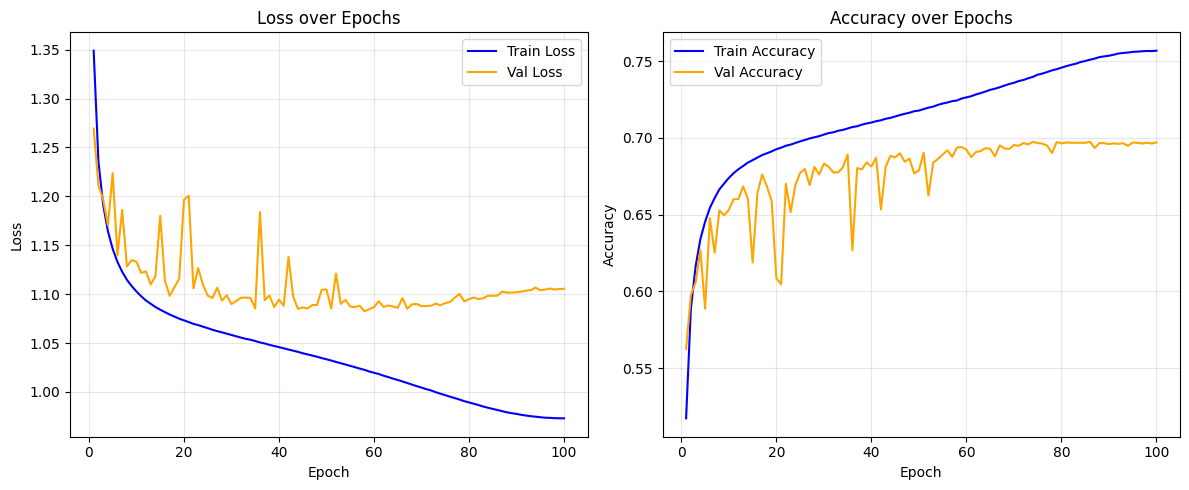

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = Path(f"./experiments/logs/{model_save_name}/{RUN_ID}_learning_curves.csv")
df = pd.read_csv(file_path)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue')
plt.plot(df['epoch'], df['val_loss'], label='Val Loss', color='orange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(df['epoch'], df['train_acc'], label='Train Accuracy', color='blue')
plt.plot(df['epoch'], df['val_acc'], label='Val Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()